# EDA: Time Series Forecasting

Exploratory analysis of `train.parquet`: sub_category, code, sub_code, horizon, ts_index vs y_target. See `../docs/EDA_OBSERVATIONS.md` for documented findings.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 1000)


In [38]:
pdf = pd.read_parquet('../data/train.parquet')


## EDA: sub_category, code, sub_code, horizon, ts_index vs y_target

Exploring relationships between identifiers, time, and target to inform preprocessing and modeling.

In [39]:
# 1) Cardinality and value counts
cols_meta = ['sub_category', 'code', 'sub_code', 'horizon', 'ts_index']
for c in cols_meta:
    n = pdf[c].nunique()
    print(f"{c}: {n} unique values")
print()
# Value counts for categoricals
print("--- sub_category ---")
print(pdf['sub_category'].value_counts().sort_index())
print("\n--- horizon ---")
print(pdf['horizon'].value_counts().sort_index())
print("\n--- ts_index range ---")
print(f"min={pdf['ts_index'].min()}, max={pdf['ts_index'].max()}, span={pdf['ts_index'].max() - pdf['ts_index'].min()}")

sub_category: 5 unique values
code: 23 unique values
sub_code: 180 unique values
horizon: 4 unique values
ts_index: 3601 unique values

--- sub_category ---
sub_category
DPPUO5X2    1072705
NQ58FVQM    1067164
PHHHVYZI    1067164
PZ9S1Z4V    1074239
V8BKY1IV    1056142
Name: count, dtype: int64

--- horizon ---
horizon
1     1394653
3     1385816
10    1337236
25    1219709
Name: count, dtype: int64

--- ts_index range ---
min=1, max=3601, span=3600


In [40]:
# 2) y_target distribution (overall and by categorical)
print("y_target overall:")
print(pdf['y_target'].describe())
print("\n--- y_target by sub_category (mean, std, count) ---")
by_sub = pdf.groupby('sub_category')['y_target'].agg(['mean', 'std', 'count'])
print(by_sub.sort_values('mean'))
print("\n--- y_target by horizon (mean, std, count) ---")
by_hor = pdf.groupby('horizon')['y_target'].agg(['mean', 'std', 'count'])
print(by_hor.sort_values('mean'))

y_target overall:
count    5.337414e+06
mean    -6.659048e-01
std      3.252764e+01
min     -2.201882e+03
25%     -1.290776e-01
50%     -5.774818e-04
75%      5.106807e-02
max      2.314411e+03
Name: y_target, dtype: float64

--- y_target by sub_category (mean, std, count) ---
                  mean        std    count
sub_category                              
PHHHVYZI     -1.446897  53.455295  1067164
PZ9S1Z4V     -1.217609  28.187398  1074239
NQ58FVQM     -0.997217  19.832982  1067164
DPPUO5X2     -0.180652  29.266238  1072705
V8BKY1IV      0.526302  19.532539  1056142

--- y_target by horizon (mean, std, count) ---
             mean        std    count
horizon                              
25      -1.681878  52.823280  1219709
10      -0.775965  33.842065  1337236
3       -0.252409  19.361190  1385816
1       -0.082721  11.699685  1394653


In [41]:
# 3) y_target by code (top/bottom by mean)
by_code = pdf.groupby('code')['y_target'].agg(['mean', 'std', 'count']).sort_values('mean')
print("Codes with lowest mean y_target:")
print(by_code.head(8))
print("\nCodes with highest mean y_target:")
print(by_code.tail(8))
print("\n--- y_target by sub_code (sample: 10 with most rows) ---")
sub_code_counts = pdf.groupby('sub_code').size().sort_values(ascending=False)
top_sub_codes = sub_code_counts.head(10).index.tolist()
by_subcode = pdf[pdf['sub_code'].isin(top_sub_codes)].groupby('sub_code')['y_target'].agg(['mean', 'std', 'count'])
print(by_subcode)

Codes with lowest mean y_target:
               mean         std   count
code                                   
W4S29LF4 -10.952807  142.610537  193977
QAQDDTPJ  -6.299555  109.241238  130876
10BAVIDU  -0.977455   14.637540  134886
2RBMUWP1  -0.941983   15.612861  176409
WH61ASEA  -0.659445   12.368094   74291
K7Y1TTAH  -0.595550    6.807219  324479
X9BZ68VQ  -0.166515    7.676776  209261
OSJL3A7Y  -0.041594    1.879662  564790

Codes with highest mean y_target:
              mean       std   count
code                                
SJZP0OVU -0.000056  0.002014  237283
83EG83KQ  0.000018  0.000919  118694
1HEMHZK2  0.000137  0.007241  293024
VFWIFJPS  0.000410  0.013920  318517
6LB028J8  0.003549  0.221563  484082
84J8BJFZ  0.007242  0.403669  234375
660DZME0  0.008396  2.005410  264071
HYOGKLEV  0.018635  0.213236   92259

--- y_target by sub_code (sample: 10 with most rows) ---
              mean        std  count
sub_code                            
69SD4Y3A  2.427077  38.593799 

In [42]:
# 4) Hierarchy: code -> sub_code -> sub_category
# How many sub_codes per code? How many codes per sub_category?
print("Sub_codes per code:")
print(pdf.groupby('code')['sub_code'].nunique().describe())
print("\nCodes per sub_category:")
print(pdf.groupby('sub_category')['code'].nunique())
print("\nSub_codes per sub_category:")
print(pdf.groupby('sub_category')['sub_code'].nunique())

Sub_codes per code:
count     23.000000
mean      80.695652
std       33.088634
min       39.000000
25%       57.000000
50%       72.000000
75%      102.500000
max      176.000000
Name: sub_code, dtype: float64

Codes per sub_category:
sub_category
DPPUO5X2    23
NQ58FVQM    23
PHHHVYZI    23
PZ9S1Z4V    23
V8BKY1IV    23
Name: code, dtype: int64

Sub_codes per sub_category:
sub_category
DPPUO5X2    180
NQ58FVQM    180
PHHHVYZI    180
PZ9S1Z4V    180
V8BKY1IV    180
Name: sub_code, dtype: int64


In [43]:
# 5) Cross-tabs: mean y_target by (sub_category, horizon) and (code, horizon)
print("Mean y_target by (sub_category, horizon):")
ct_sc_h = pdf.pivot_table(values='y_target', index='sub_category', columns='horizon', aggfunc='mean')
print(ct_sc_h.round(6))
print("\nMean y_target by (code, horizon) - sample first 5 codes:")
codes_sample = pdf['code'].unique()[:5]
ct_c_h = pdf[pdf['code'].isin(codes_sample)].pivot_table(values='y_target', index='code', columns='horizon', aggfunc='mean')
print(ct_c_h.round(6))

Mean y_target by (sub_category, horizon):
horizon             1         3         10        25
sub_category                                        
DPPUO5X2     -0.073170 -0.176608 -0.263271 -0.217943
NQ58FVQM     -0.057507 -0.222511 -1.039921 -2.905709
PHHHVYZI     -0.204334 -0.602170 -1.678069 -3.574588
PZ9S1Z4V     -0.139709 -0.419614 -1.350344 -3.222805
V8BKY1IV      0.063709  0.165175  0.463132  1.526316

Mean y_target by (code, horizon) - sample first 5 codes:
horizon         1         3         10         25
code                                             
2RBMUWP1 -0.136989 -0.350330 -1.055789  -2.392555
660DZME0 -0.000061  0.004399  0.012248   0.018476
OSJL3A7Y -0.006584 -0.009801 -0.038823  -0.121341
QAQDDTPJ -0.655491 -2.110390 -7.161738 -16.356842
W2MW3G2L -0.002644 -0.006819 -0.025027  -0.061215


In [44]:
code_arr = pdf['code'].unique()
code_arr


<ArrowStringArray>
['W2MW3G2L', 'OSJL3A7Y', '660DZME0', '2RBMUWP1', 'QAQDDTPJ', 'W4S29LF4',
 '10BAVIDU', 'MLAAMU3K', 'K7Y1TTAH', 'VFWIFJPS', 'CXEQN6KB', '1HEMHZK2',
 'MRV5UON2', 'HYOGKLEV', 'X9BZ68VQ', 'WH61ASEA', '6LB028J8', 'EP12UF2K',
 'K8I5QG74', 'SJZP0OVU', '4KUR2ZOZ', '84J8BJFZ', '83EG83KQ']
Length: 23, dtype: str

In [45]:
code_idx = 4
unique_combos = pdf[['code', 'sub_code', 'sub_category']][pdf['code'] == code_arr[code_idx]].drop_duplicates().reset_index(drop=True)
print("Unique combinations of code, sub_code, sub_category:", unique_combos.shape[0])

Unique combinations of code, sub_code, sub_category: 195


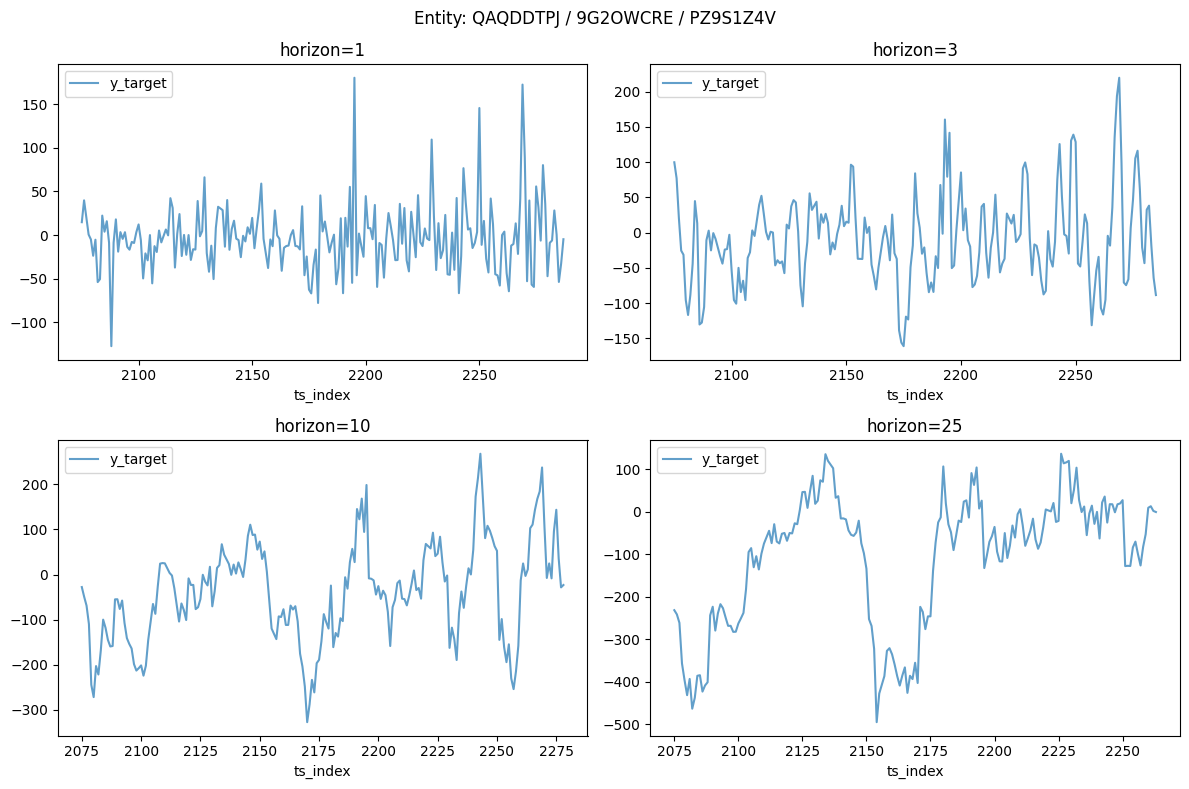

In [46]:
# 6) ts_index vs y_target: temporal coverage and rolling mean by group
# Sample one (code, sub_code, sub_category) and plot y_target over ts_index for each horizon
import matplotlib.pyplot as plt
combo_idx = 1
sample_code = unique_combos['code'].iloc[combo_idx]
sample_sub = unique_combos['sub_code'].iloc[combo_idx]
sample_cat = unique_combos['sub_category'].iloc[combo_idx]


mask = (pdf['code'] == sample_code) & (pdf['sub_code'] == sample_sub) & (pdf['sub_category'] == sample_cat)
sample_df = pdf.loc[mask].sort_values('ts_index')
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
for ax, (h, grp) in zip(axes.flat, sample_df.groupby('horizon')):
    grp = grp.sort_values('ts_index')
    ax.plot(grp['ts_index'], grp['y_target'], alpha=0.7, label='y_target')
    ax.set_title(f'horizon={h}')
    ax.set_xlabel('ts_index')
    ax.legend()
plt.suptitle(f'Entity: {sample_code} / {sample_sub} / {sample_cat}')
plt.tight_layout()
plt.show()

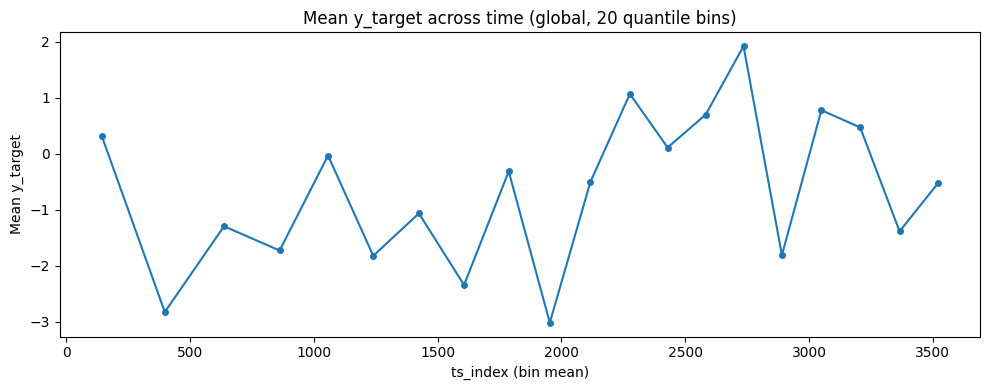

In [47]:
# 7) Global: mean y_target over ts_index (binned) to see trend
bins = pd.qcut(pdf['ts_index'], q=20, duplicates='drop')
ts_agg = pdf.groupby(bins).agg({'y_target': 'mean', 'ts_index': 'mean', 'weight': 'sum'})
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(ts_agg['ts_index'], ts_agg['y_target'], marker='o', markersize=4)
ax.set_xlabel('ts_index (bin mean)')
ax.set_ylabel('Mean y_target')
ax.set_title('Mean y_target across time (global, 20 quantile bins)')
plt.tight_layout()
plt.show()

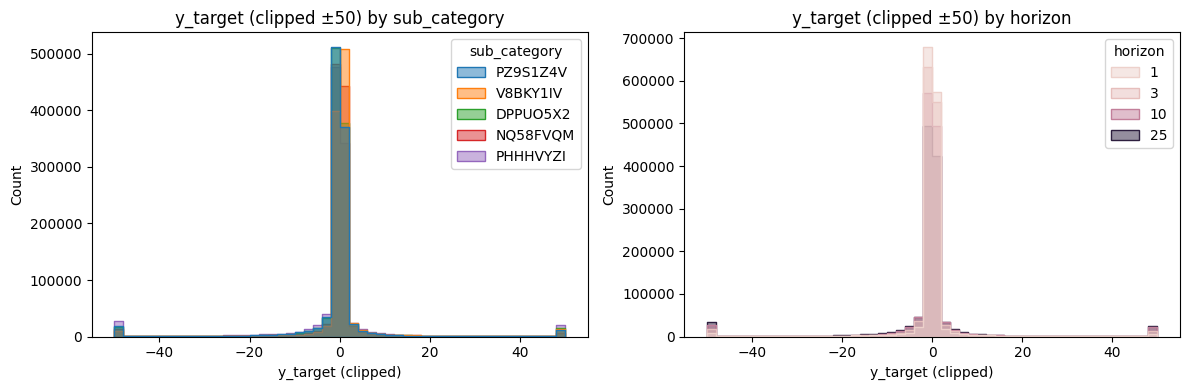

In [48]:
# 8) Histograms: y_target by sub_category and by horizon
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
# Clip extreme y_target for visibility
y_clip = pdf['y_target'].clip(-50, 50)
pdf_temp = pdf.assign(y_clip=y_clip)
sns.histplot(data=pdf_temp, x='y_clip', hue='sub_category', ax=axes[0], bins=50, alpha=0.5, element='step')
axes[0].set_title('y_target (clipped ±50) by sub_category')
axes[0].set_xlabel('y_target (clipped)')
sns.histplot(data=pdf_temp, x='y_clip', hue='horizon', ax=axes[1], bins=50, alpha=0.5, element='step')
axes[1].set_title('y_target (clipped ±50) by horizon')
axes[1].set_xlabel('y_target (clipped)')
plt.tight_layout()
plt.show()

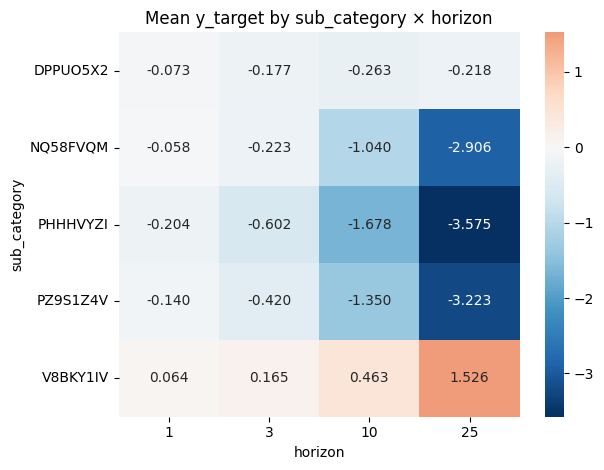

In [49]:
# 9) Heatmap: mean y_target by (sub_category, horizon)
import seaborn as sns
ct = pdf.pivot_table(values='y_target', index='sub_category', columns='horizon', aggfunc='mean')
sns.heatmap(ct, annot=True, fmt='.3f', cmap='RdBu_r', center=0)
plt.title('Mean y_target by sub_category × horizon')
plt.tight_layout()
plt.show()

In [50]:
# 10) Row counts: how many (code, sub_code, sub_category, horizon) combinations per ts_index?
# And distribution of ts_index counts per entity
entity = pdf.groupby(['code', 'sub_code', 'sub_category', 'horizon']).size()
print("Rows per (code, sub_code, sub_category, horizon):")
print(entity.describe())
print("\nTs_index coverage per entity (nunique ts_index):")
ts_per_entity = pdf.groupby(['code', 'sub_code', 'sub_category', 'horizon'])['ts_index'].nunique()
print(ts_per_entity.describe())

Rows per (code, sub_code, sub_category, horizon):
count    36923.000000
mean       144.555264
std         56.770160
min          1.000000
25%        104.000000
50%        166.000000
75%        194.000000
max        213.000000
dtype: float64

Ts_index coverage per entity (nunique ts_index):
count    36923.000000
mean       144.555264
std         56.770160
min          1.000000
25%        104.000000
50%        166.000000
75%        194.000000
max        213.000000
Name: ts_index, dtype: float64


In [51]:
# Numerical histograms for ALL features (detailed, for distribution analysis and transformation planning)
import numpy as np
from scipy import stats

def print_elaborate_histogram(col, data, bins=50):
    """Print detailed distribution summary for feature transformation planning."""
    data_clean = data.dropna()
    counts, bin_edges = np.histogram(data_clean, bins=bins)
    
    # Basic stats
    mean = data_clean.mean()
    median = data_clean.median()
    std = data_clean.std()
    min_val, max_val = data_clean.min(), data_clean.max()
    
    # Shape: skewness and kurtosis (for distribution type and tail behavior)
    skew = stats.skew(data_clean)
    kurt = stats.kurtosis(data_clean)  # excess kurtosis (normal=0)
    
    # Quantiles
    q01, q05, q95, q99 = data_clean.quantile([0.01, 0.05, 0.95, 0.99])
    
    # Outlier info: % outside [Q05, Q95]
    pct_extreme = ((data_clean < q05) | (data_clean > q95)).mean() * 100
    
    print(f"=== {col} (n={len(data_clean)}, bins={bins}) ===")
    print(f"  Range:      [{min_val:.6g}, {max_val:.6g}]")
    print(f"  Mean:       {mean:.6g},  Median: {median:.6g},  Std: {std:.6g}")
    print(f"  Skewness:   {skew:.4f},  Kurtosis: {kurt:.4f}  (skew>0 → right tail; kurt>0 → heavy tails)")
    print(f"  Quantiles:  Q01={q01:.6g}, Q05={q05:.6g}, Q95={q95:.6g}, Q99={q99:.6g}")
    print(f"  Extreme:    {pct_extreme:.2f}% outside [Q05, Q95]")
    print(f"  Histogram bin_edges (first 5): {bin_edges[:5].round(4).tolist()}")
    print(f"            bin_edges (last 5):  {bin_edges[-5:].round(4).tolist()}")
    print(f"  Histogram counts (first 5):    {counts[:5].tolist()}")
    print(f"            counts (last 5):     {counts[-5:].tolist()}")
    print(f"  Histogram count_sum: {counts.sum()},  count_min: {counts.min()},  count_max: {counts.max()}")
    print()

# Run for ALL numeric columns
numeric_cols = [c for c in pdf.columns if pd.api.types.is_numeric_dtype(pdf[c])]
print(f"Generating elaborate histograms for {len(numeric_cols)} numeric columns...\n")
for col in numeric_cols:
    print_elaborate_histogram(col, pdf[col], bins=50)

Generating elaborate histograms for 90 numeric columns...

=== horizon (n=5337414, bins=50) ===
  Range:      [1, 25]
  Mean:       9.25864,  Median: 3,  Std: 9.20625
  Skewness:   0.8723,  Kurtosis: -0.8220  (skew>0 → right tail; kurt>0 → heavy tails)
  Quantiles:  Q01=1, Q05=1, Q95=25, Q99=25
  Extreme:    0.00% outside [Q05, Q95]
  Histogram bin_edges (first 5): [1.0, 1.48, 1.96, 2.44, 2.92]
            bin_edges (last 5):  [23.08, 23.56, 24.04, 24.52, 25.0]
  Histogram counts (first 5):    [1394653, 0, 0, 0, 1385816]
            counts (last 5):     [0, 0, 0, 0, 1219709]
  Histogram count_sum: 5337414,  count_min: 0,  count_max: 1394653

=== ts_index (n=5337414, bins=50) ===
  Range:      [1, 3601]
  Mean:       1963.32,  Median: 2036,  Std: 997.022
  Skewness:   -0.1813,  Kurtosis: -1.0842  (skew>0 → right tail; kurt>0 → heavy tails)
  Quantiles:  Q01=66, Q05=273, Q95=3440, Q99=3570
  Extreme:    9.96% outside [Q05, Q95]
  Histogram bin_edges (first 5): [1.0, 73.0, 145.0, 217.0, 2

In [53]:
pdf.columns[-2]

'y_target'

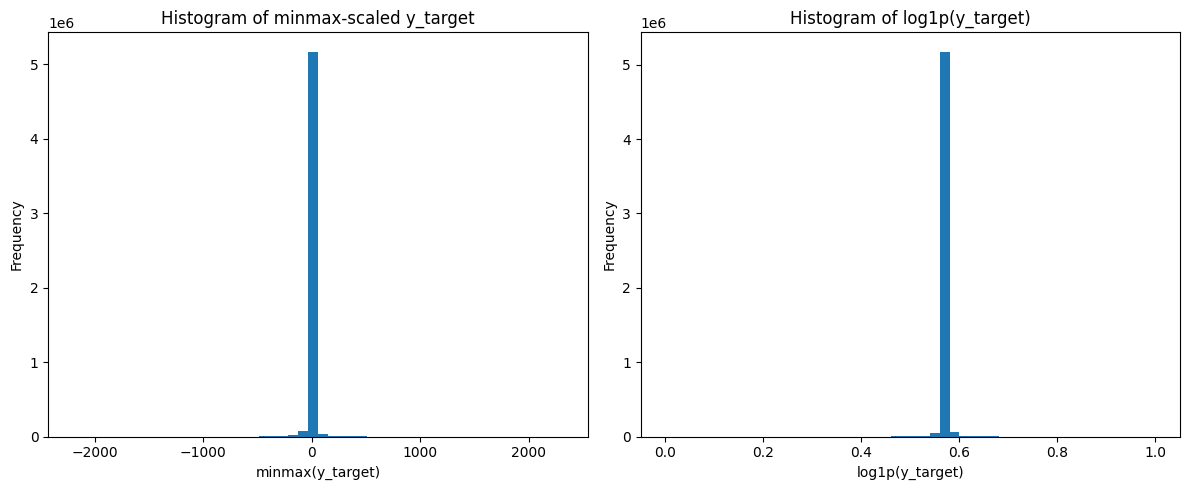

In [63]:
from sklearn.preprocessing import MinMaxScaler

y = pdf['y_target']
# Perform min-max scaling on y (result is a numpy array)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

y_log = np.log1p(y_scaled)
scaler2 = MinMaxScaler()
y_log_scaled = scaler2.fit_transform(y_log.reshape(-1, 1)).flatten()


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].hist(y[~pd.isna(y)], bins=50)
axes[0].set_title('Histogram of minmax-scaled y_target')
axes[0].set_xlabel('minmax(y_target)')
axes[0].set_ylabel('Frequency')

# Exclude -inf, inf, nan for log1p(y) (avoid crash for strange values)
y_log_clean = y_log_scaled[np.isfinite(y_log_scaled)]
axes[1].hist(y_log_clean, bins=50)
axes[1].set_title('Histogram of log1p(y_target)')
axes[1].set_xlabel('log1p(y_target)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

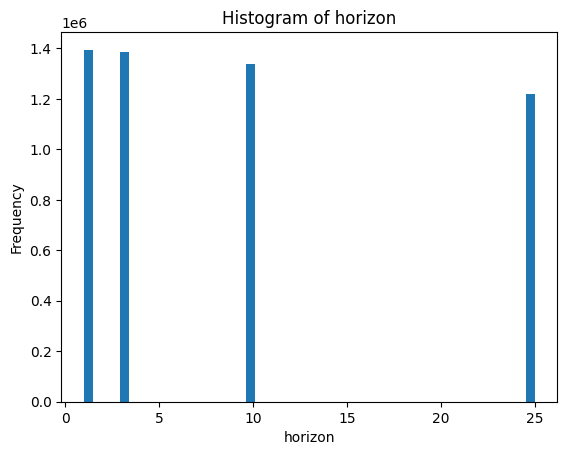

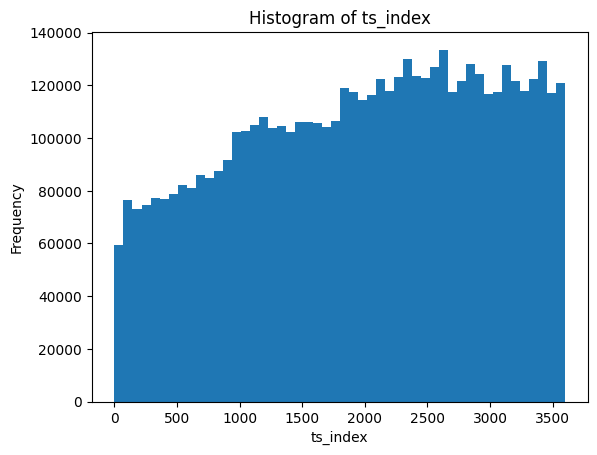

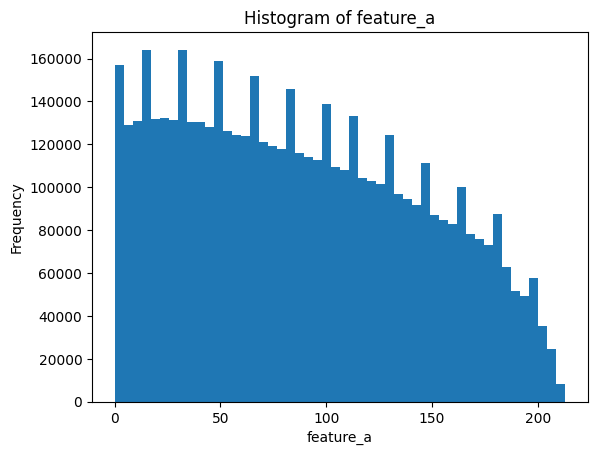

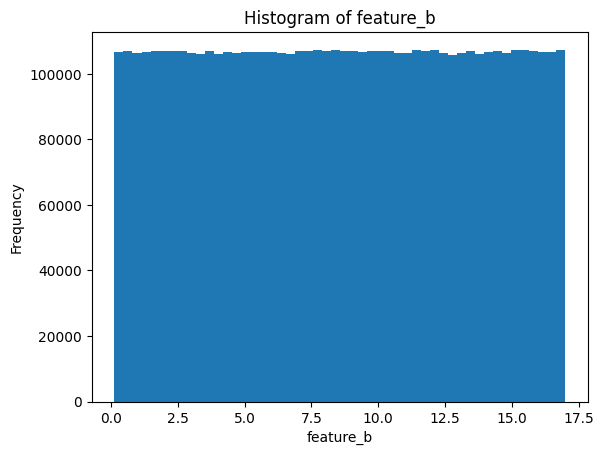

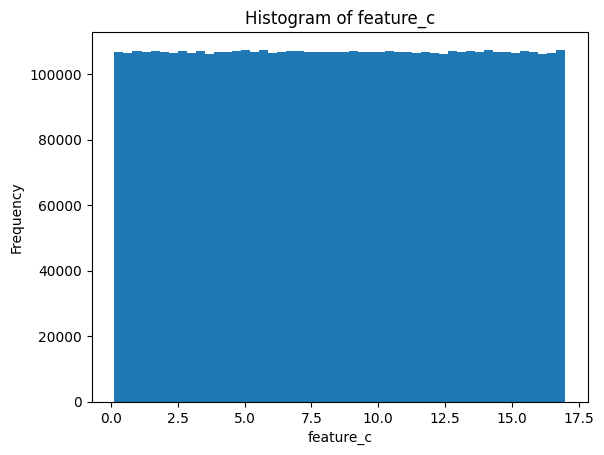

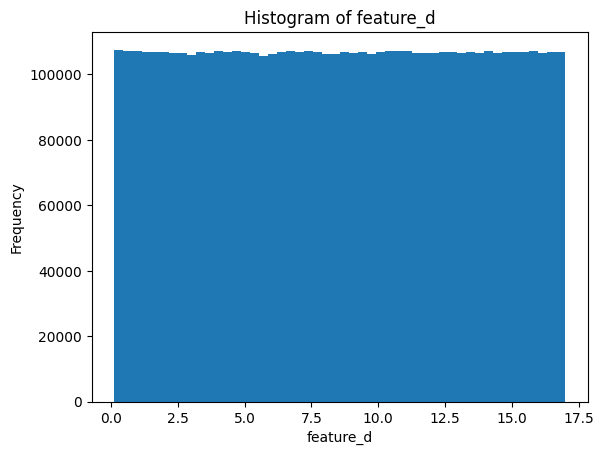

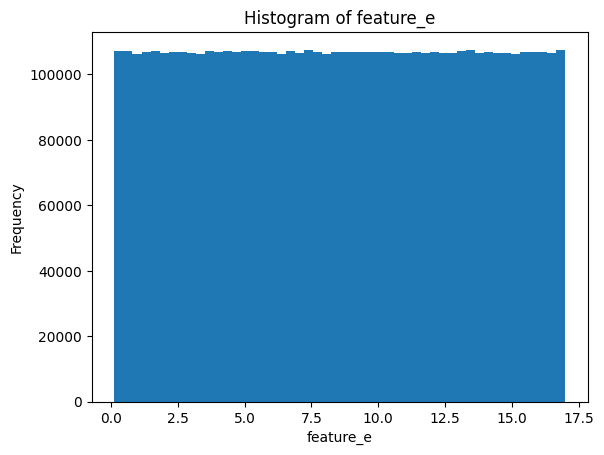

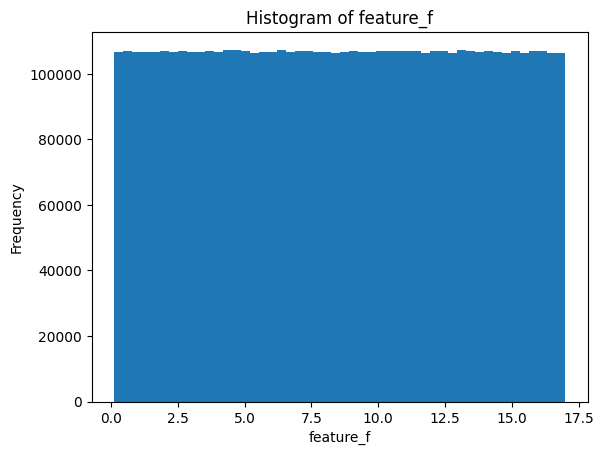

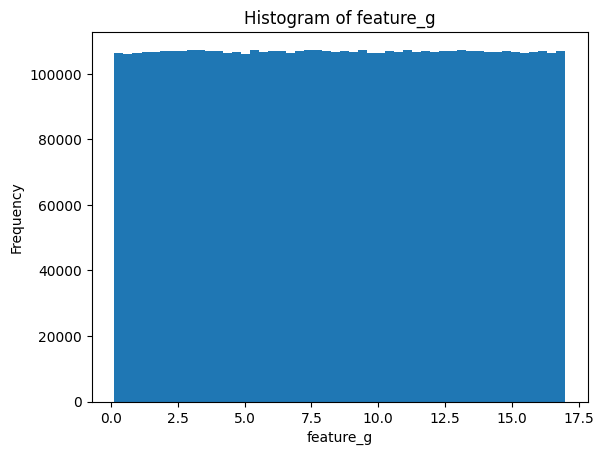

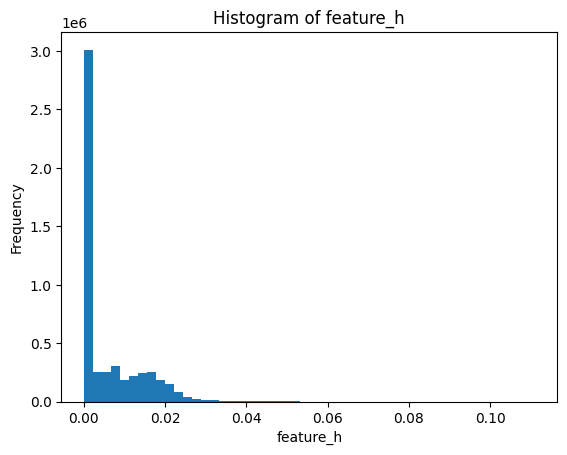

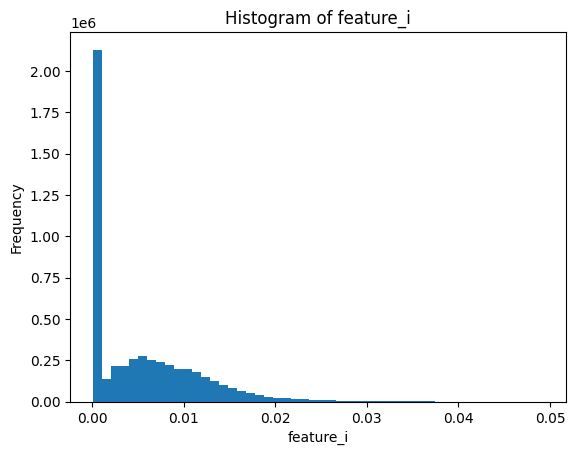

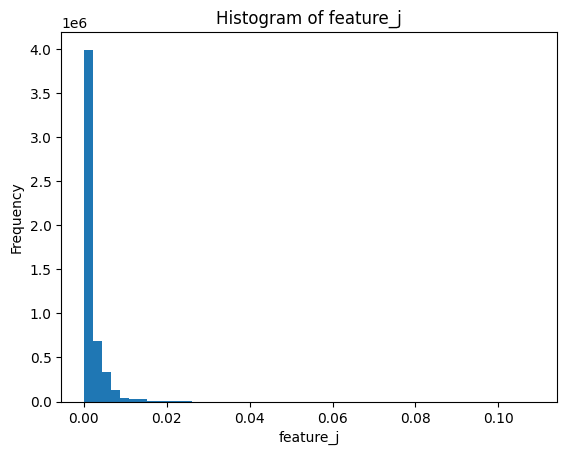

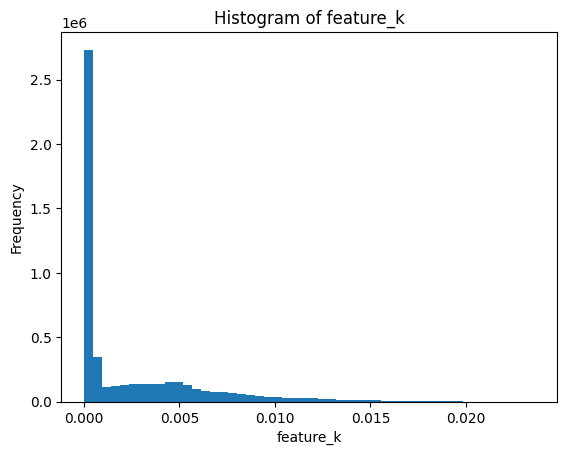

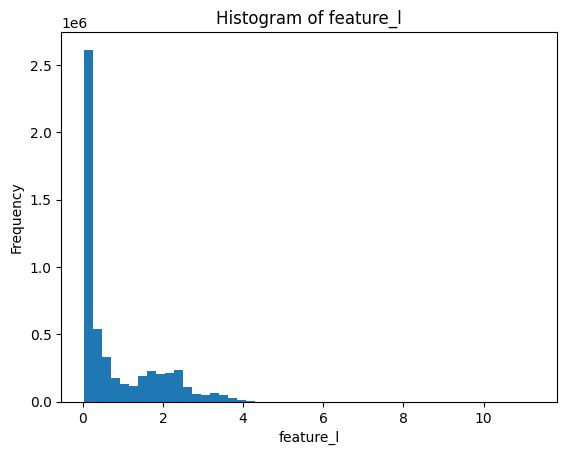

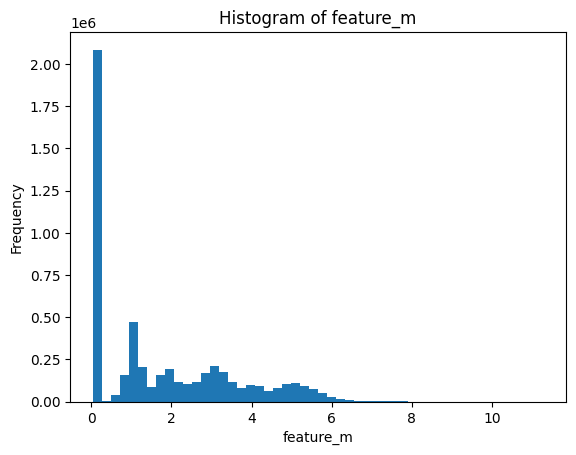

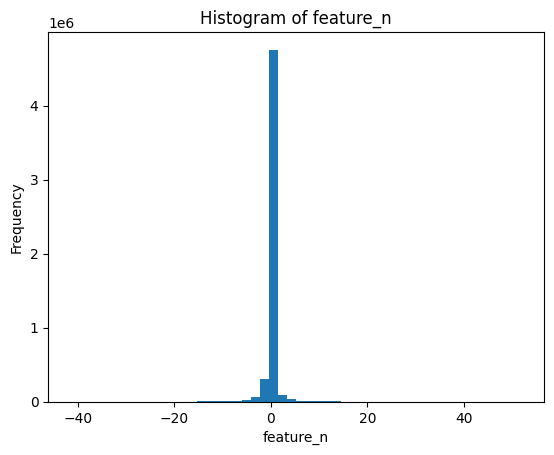

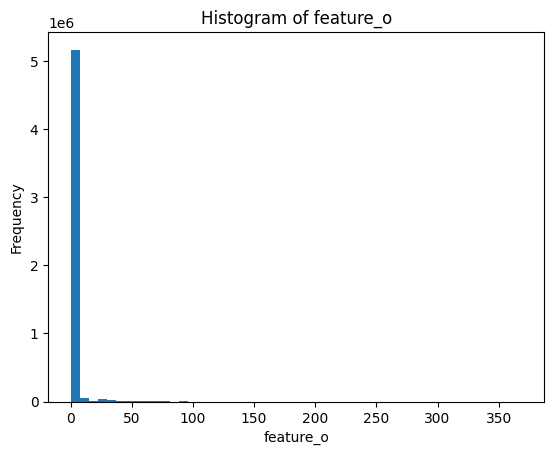

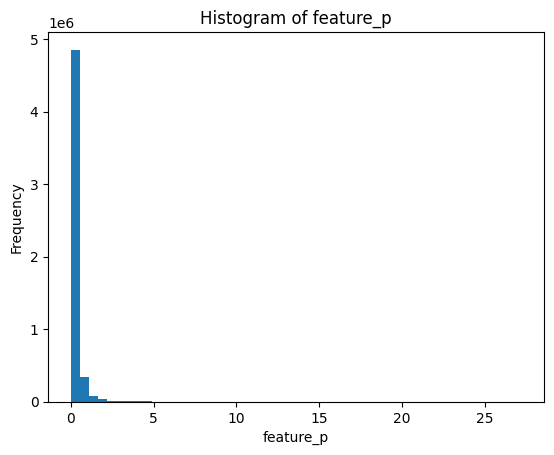

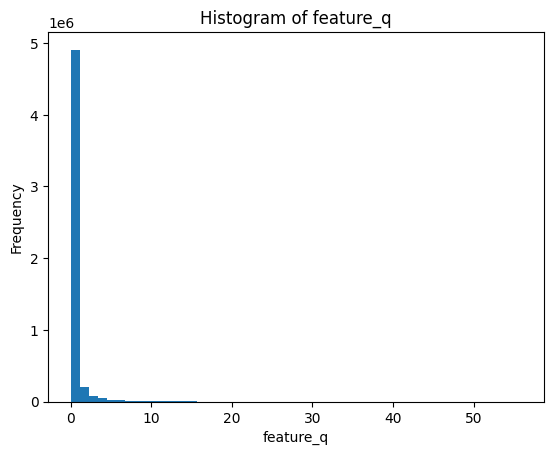

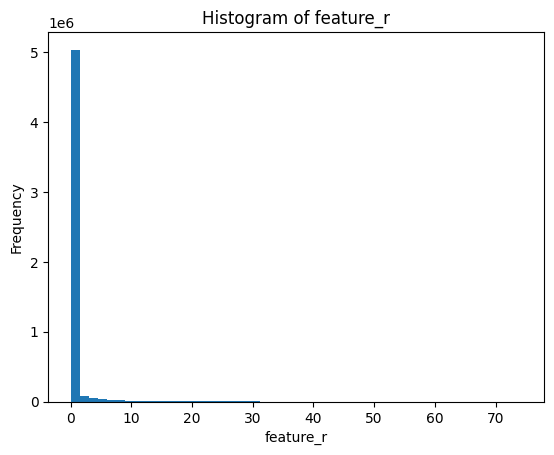

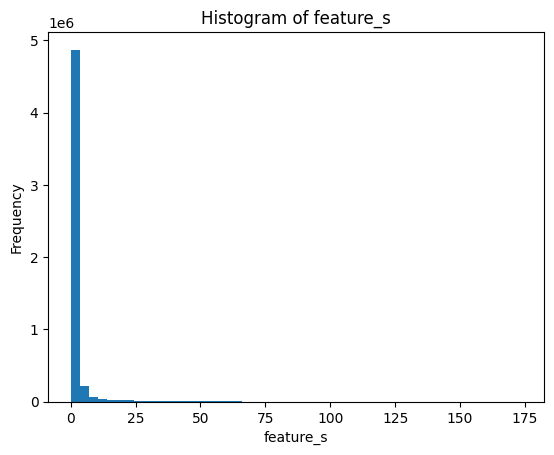

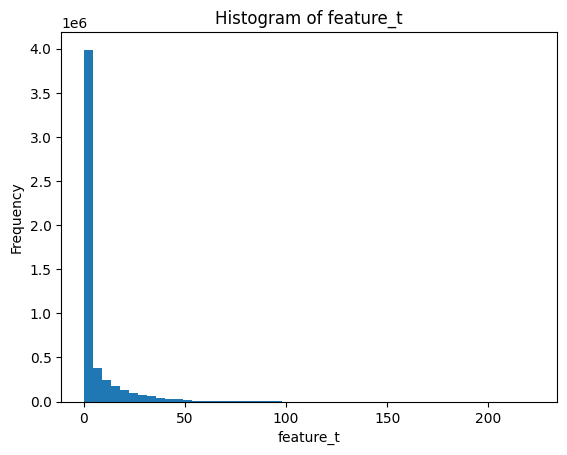

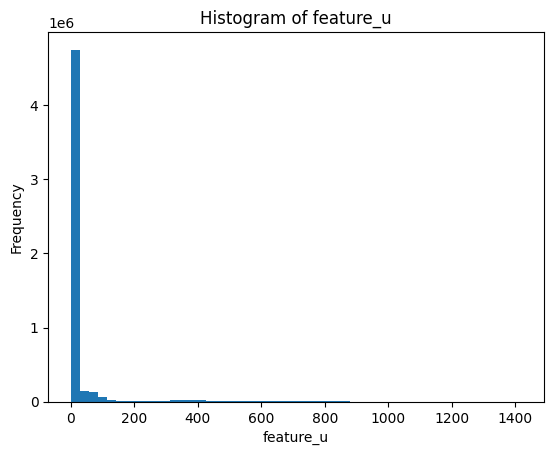

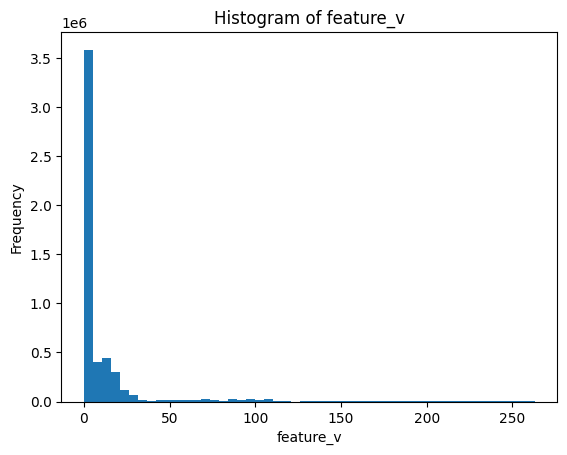

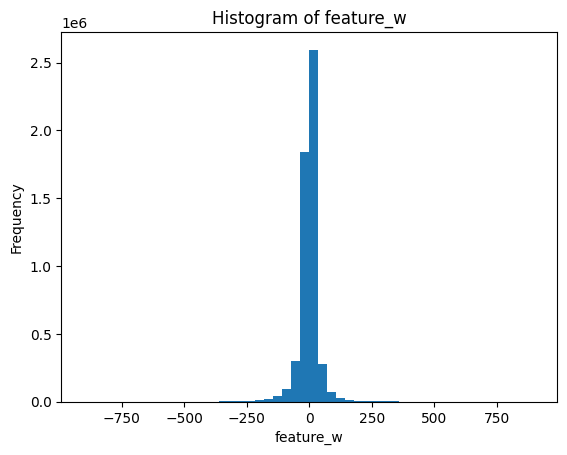

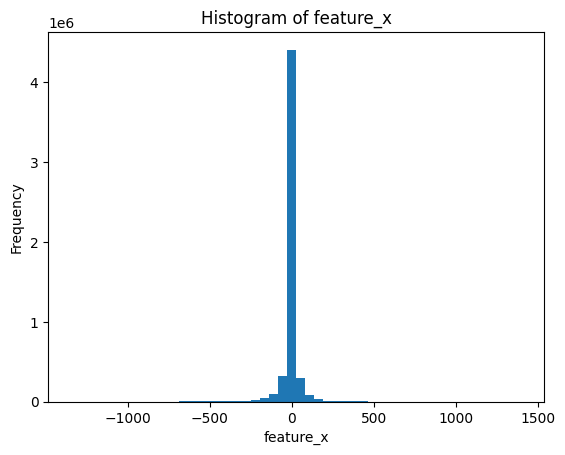

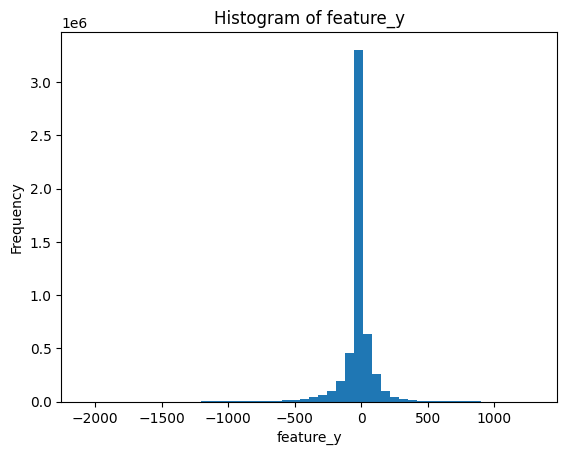

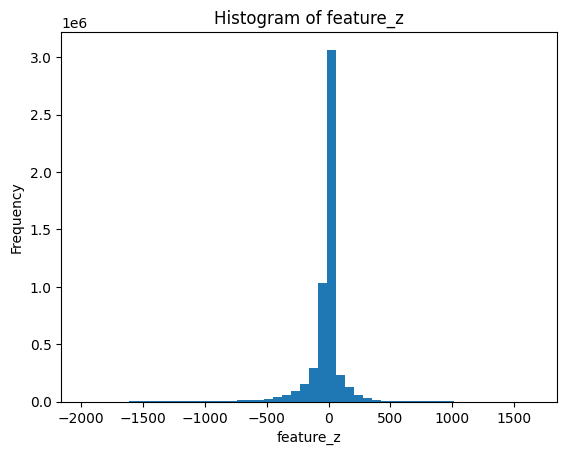

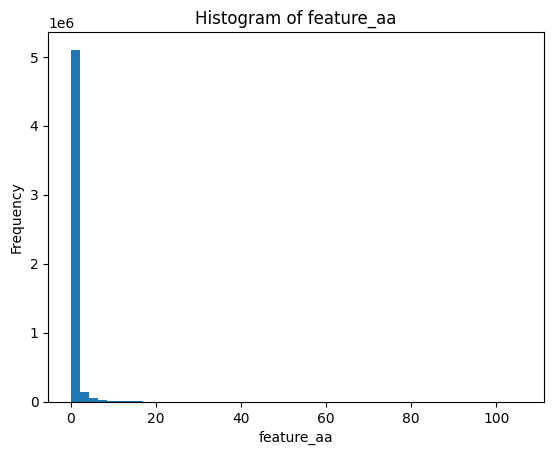

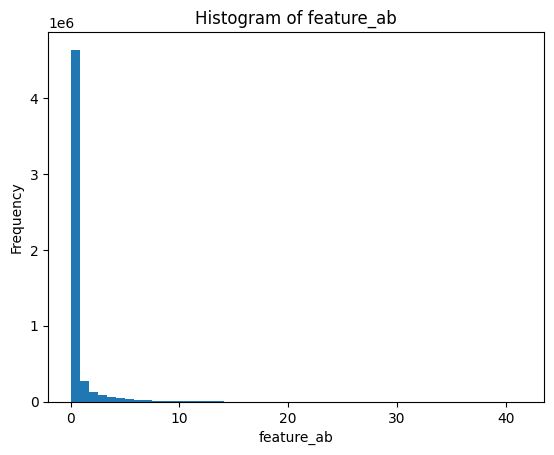

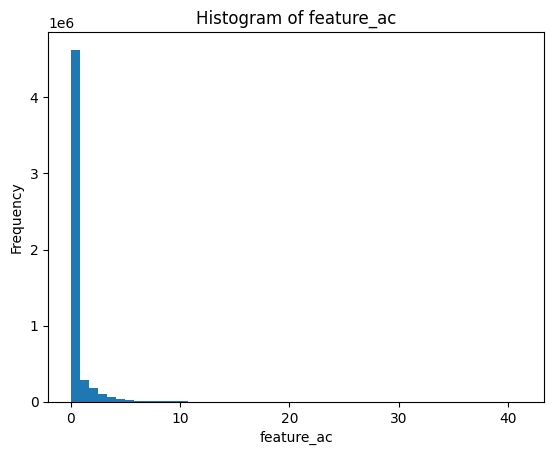

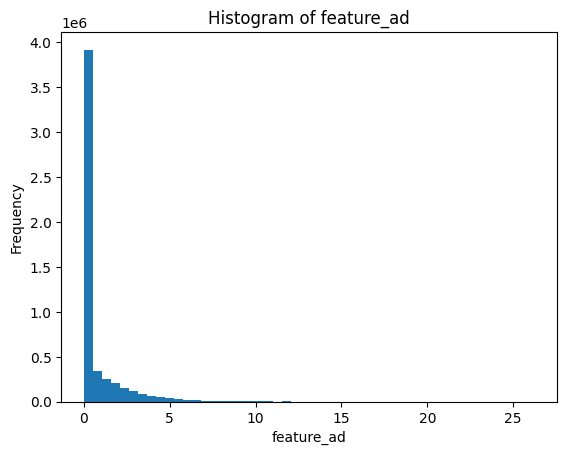

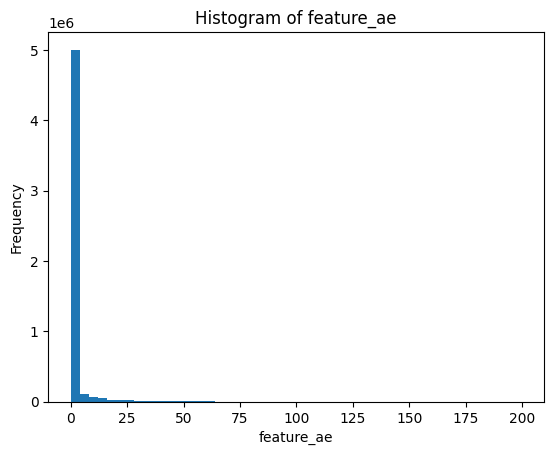

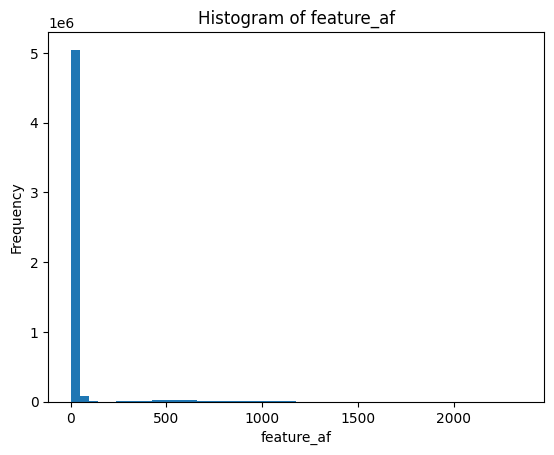

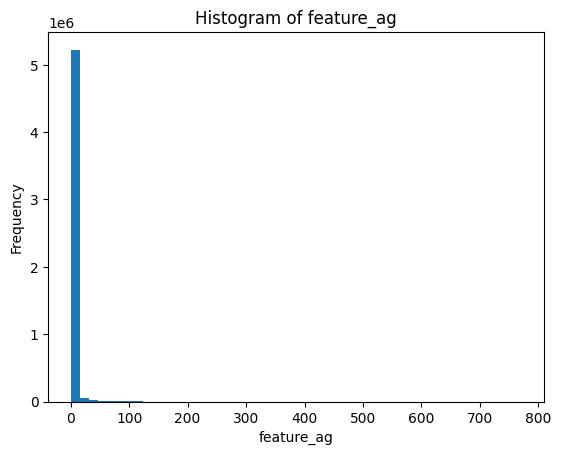

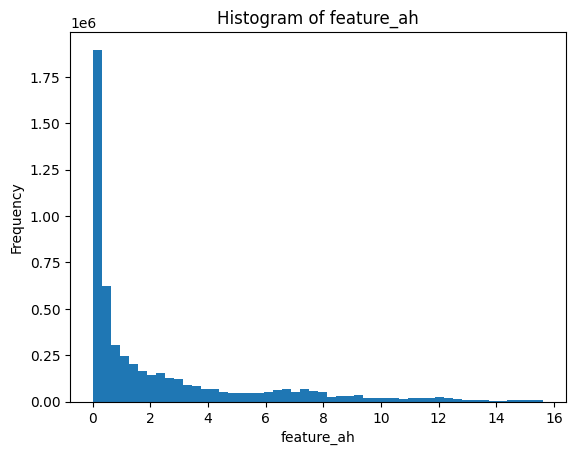

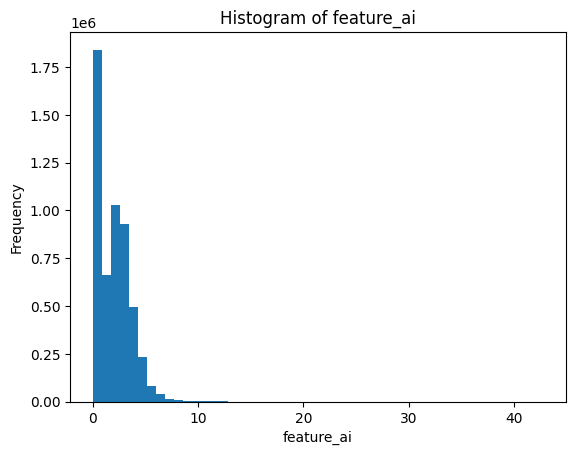

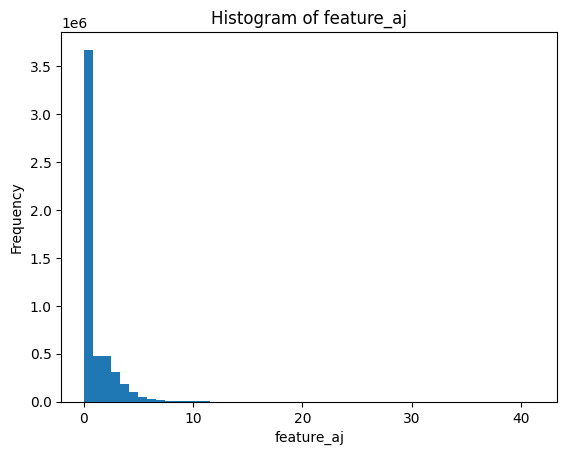

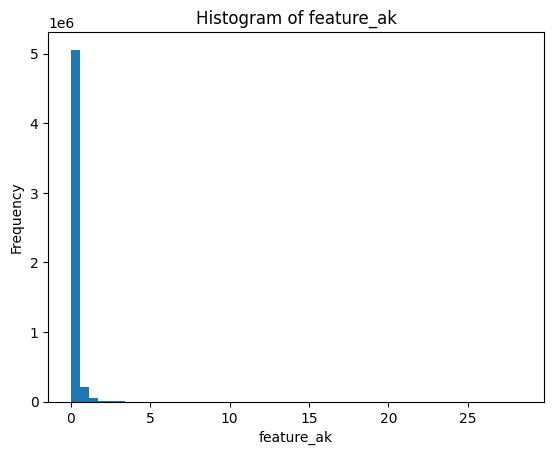

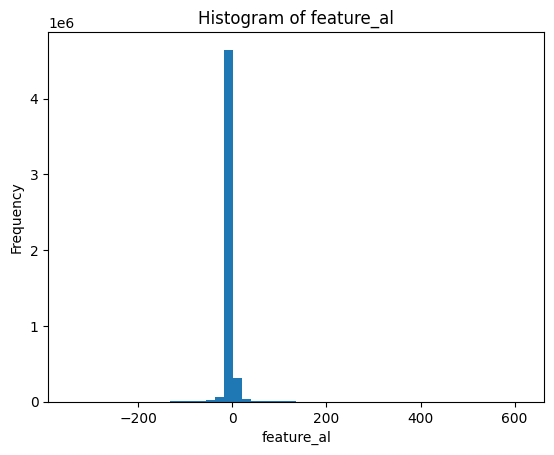

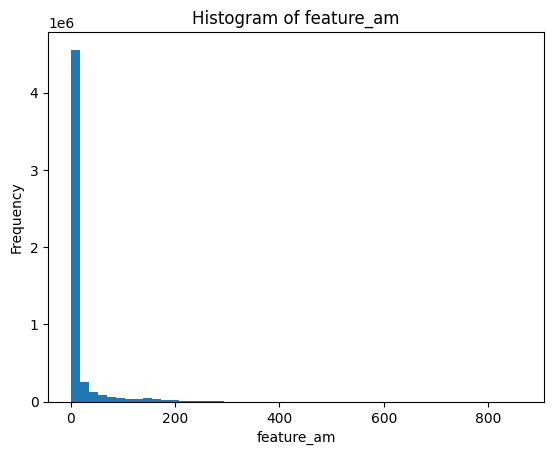

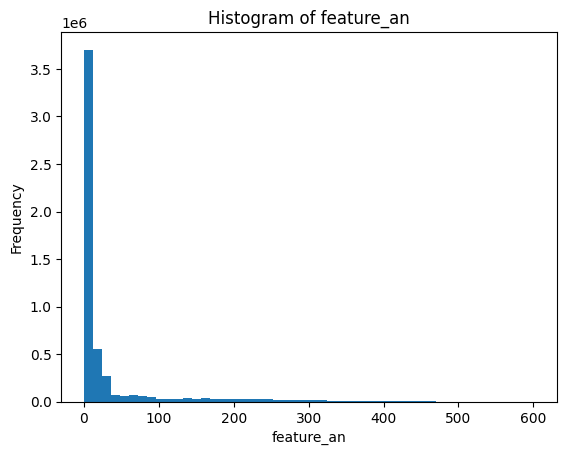

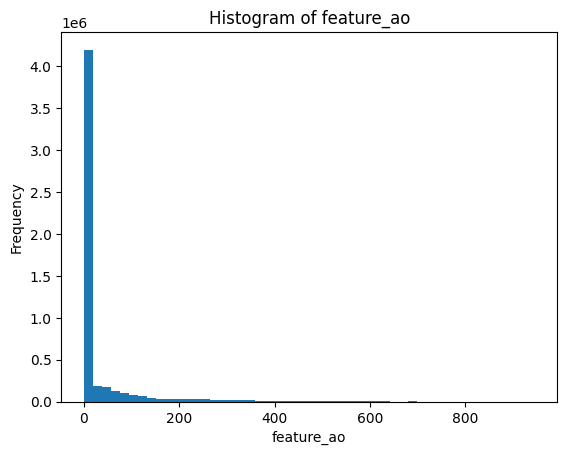

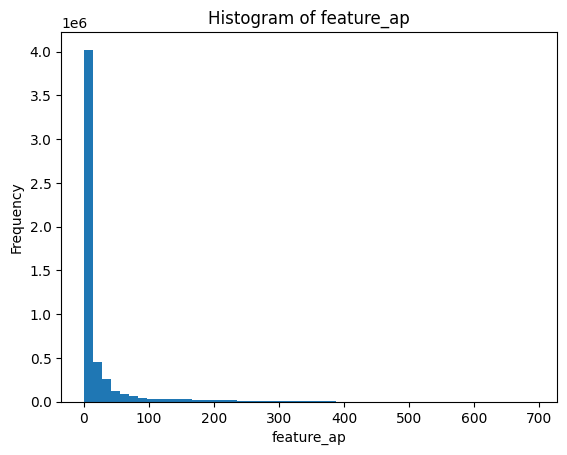

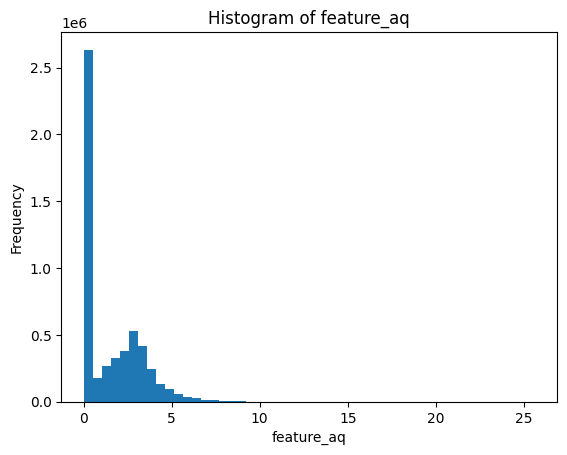

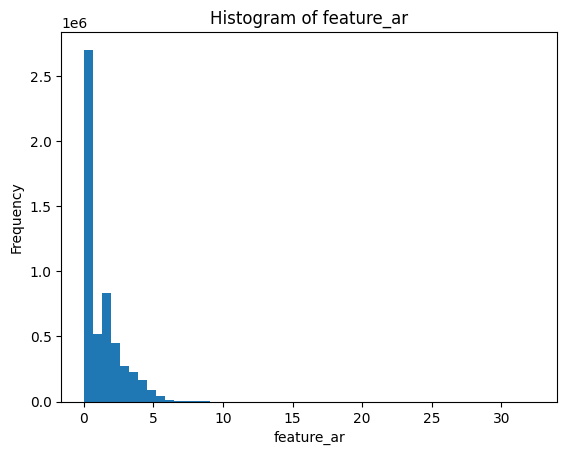

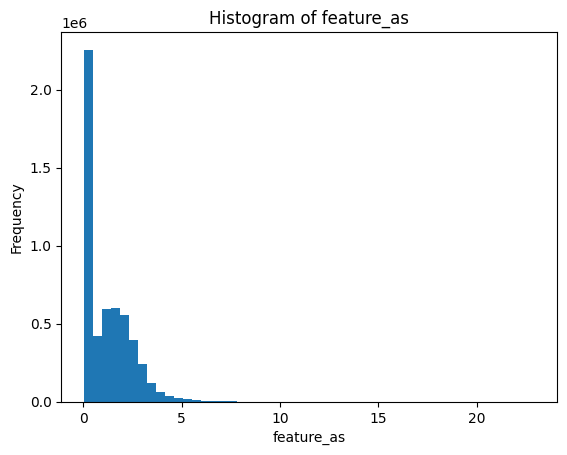

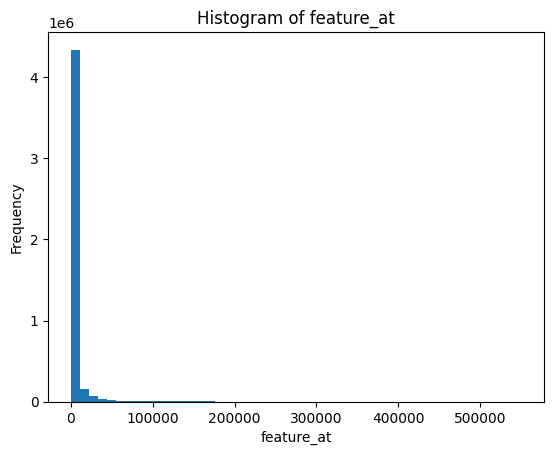

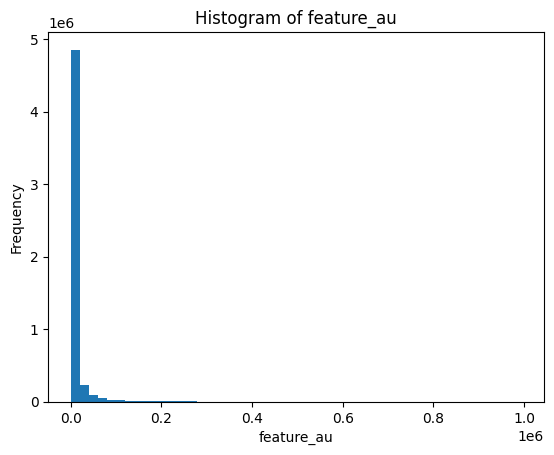

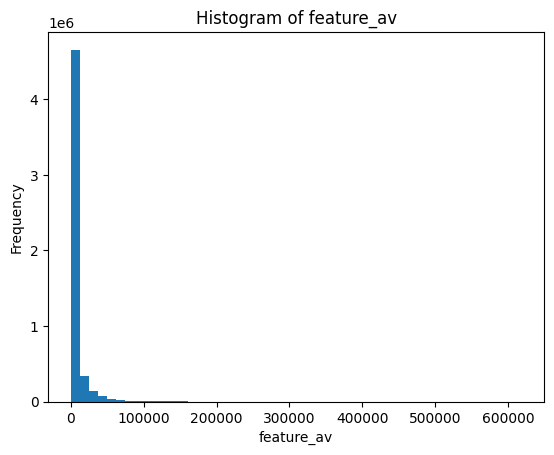

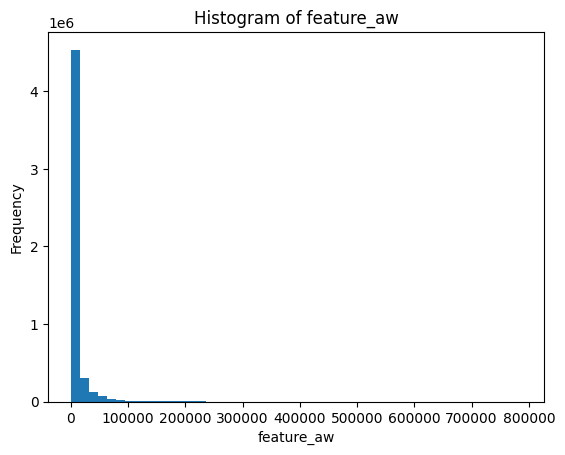

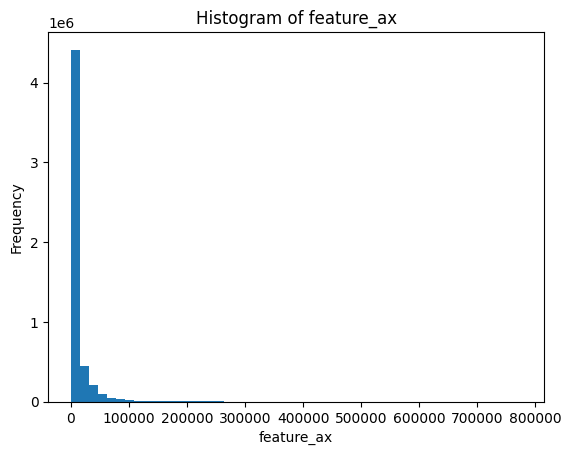

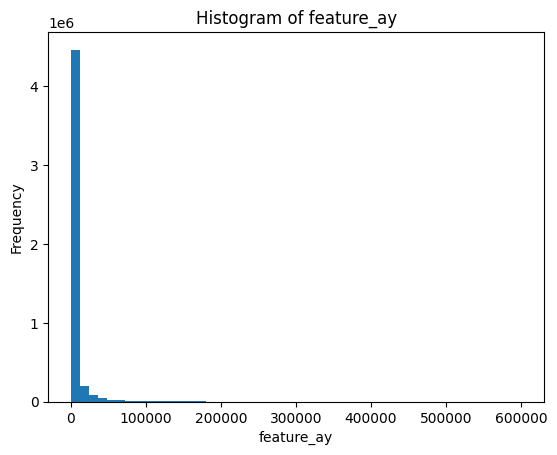

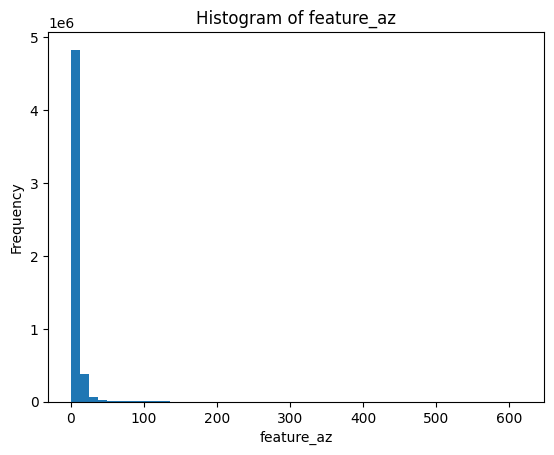

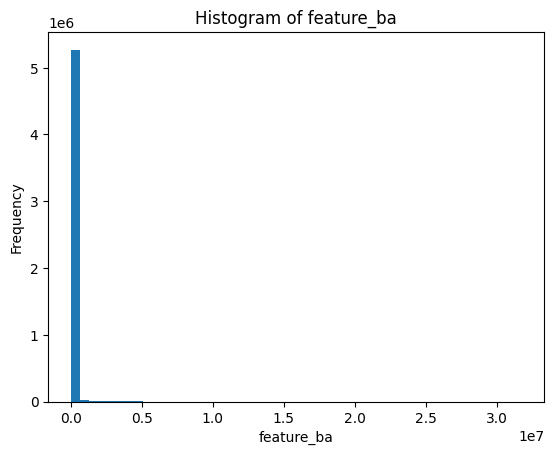

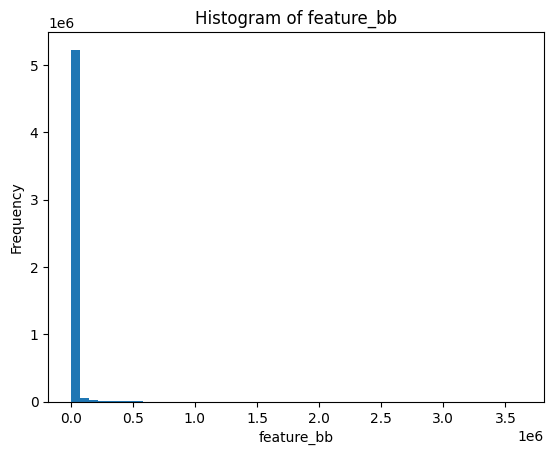

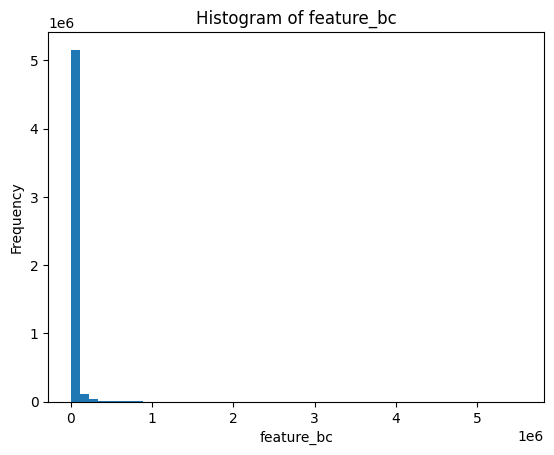

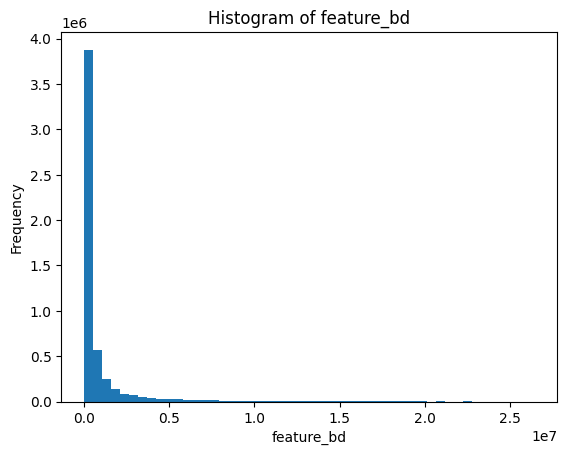

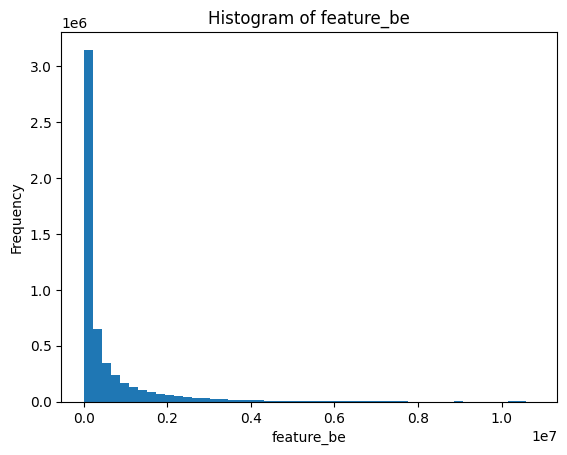

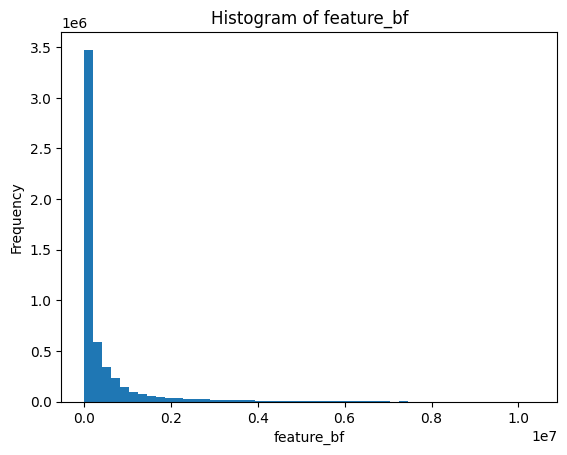

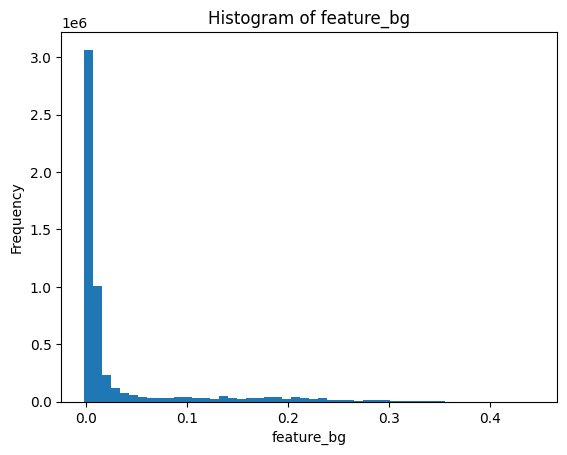

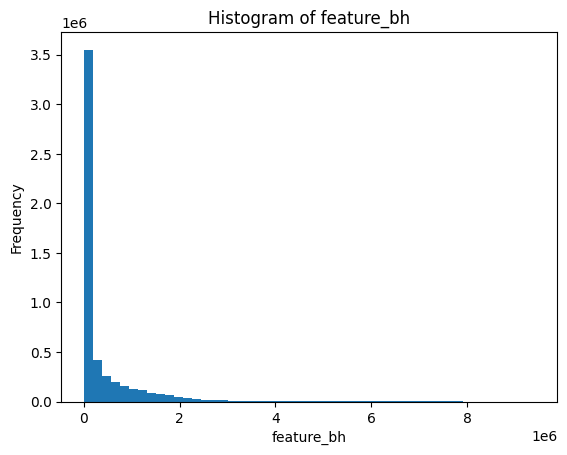

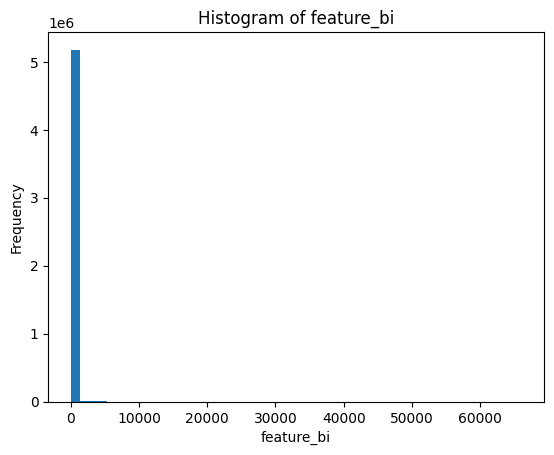

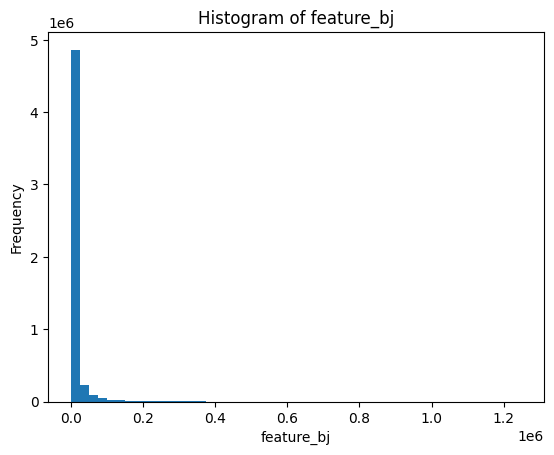

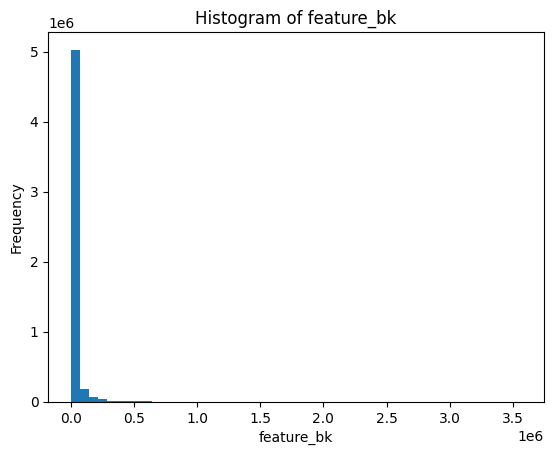

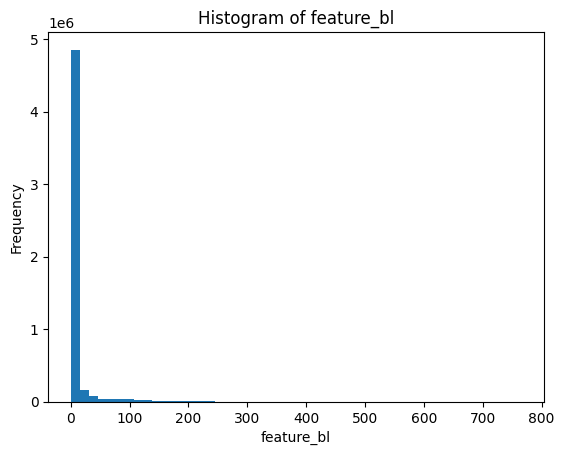

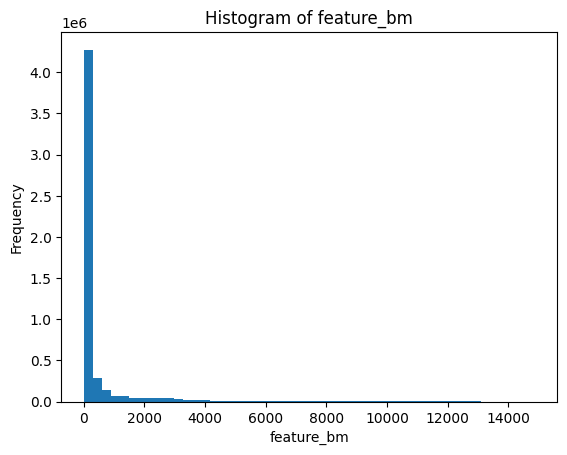

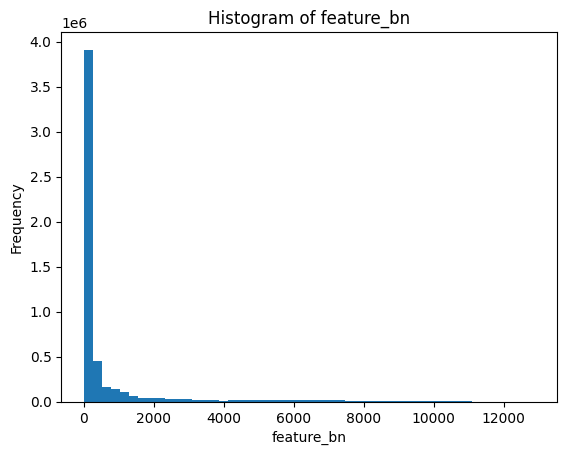

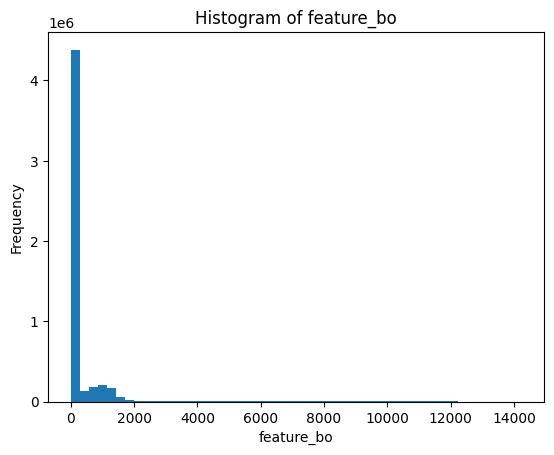

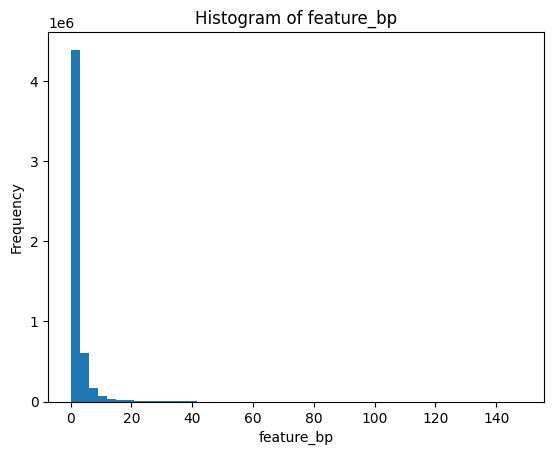

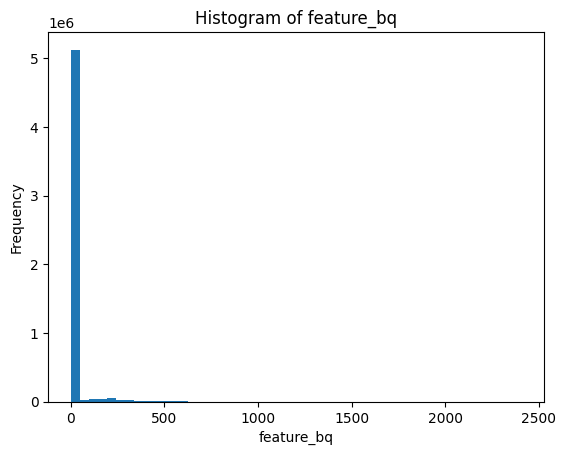

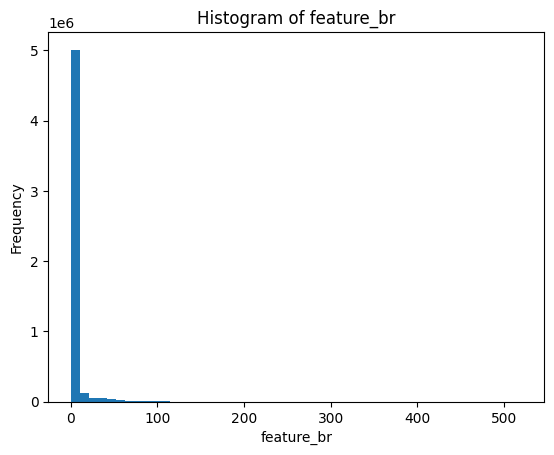

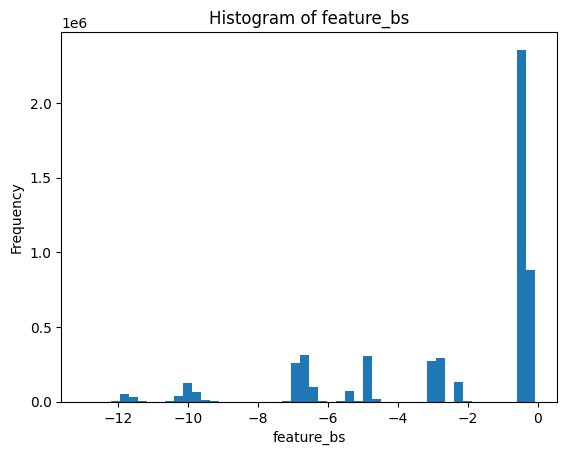

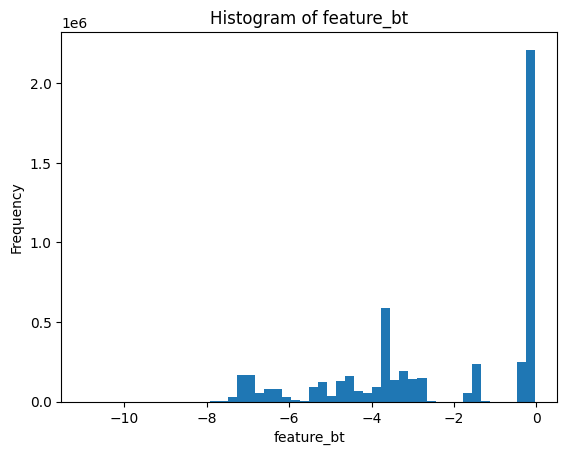

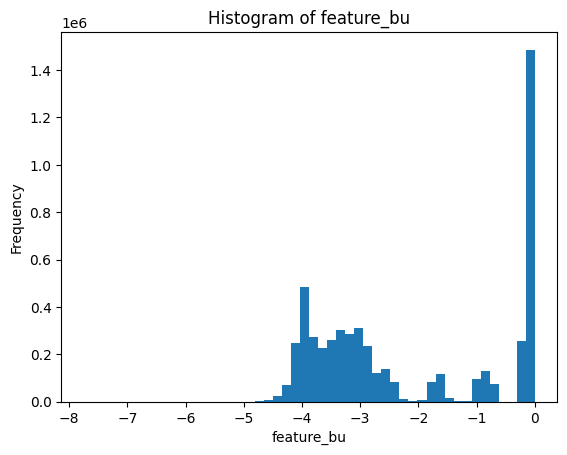

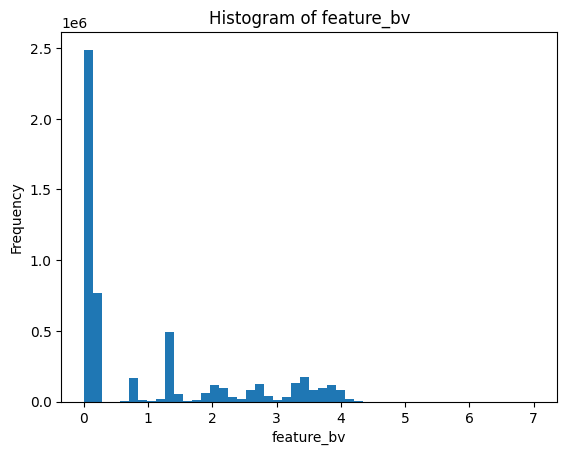

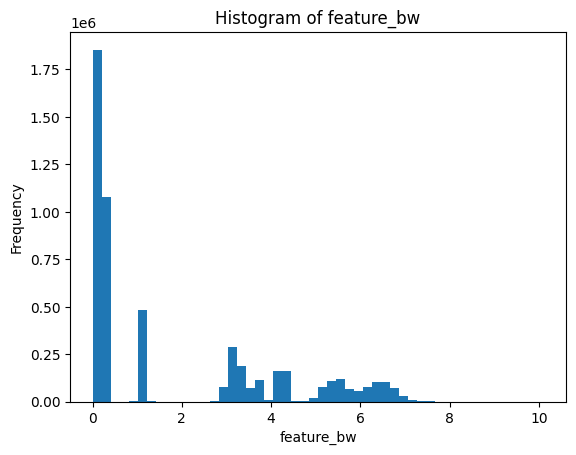

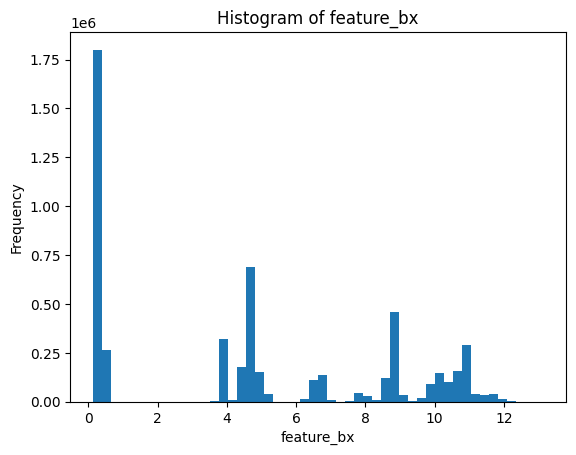

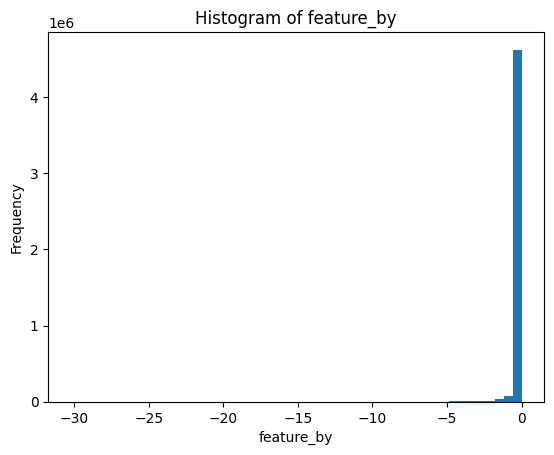

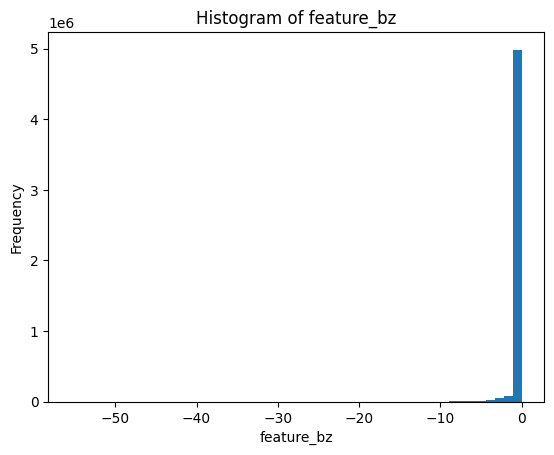

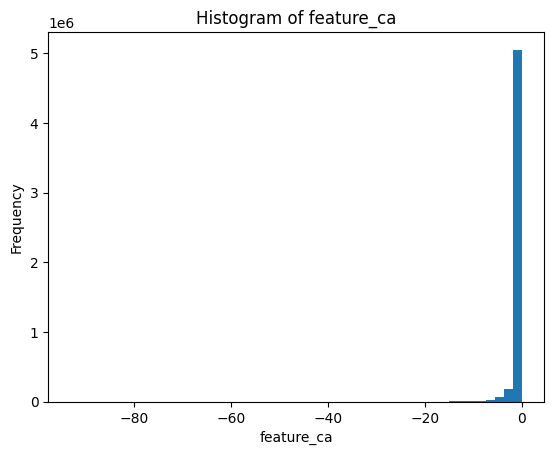

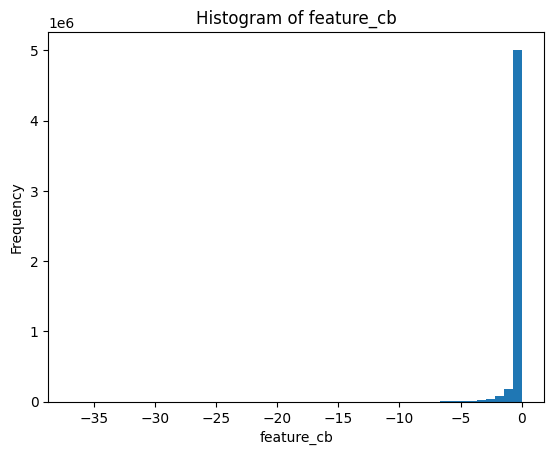

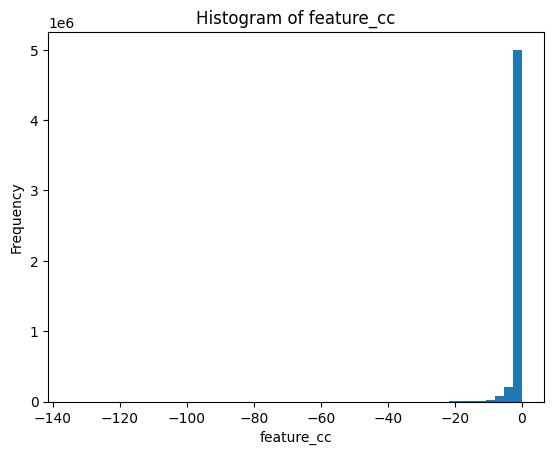

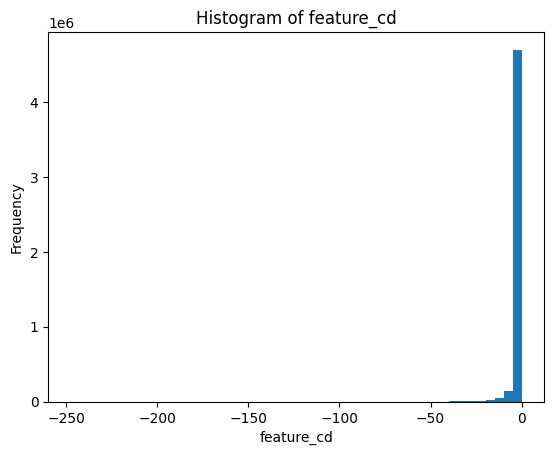

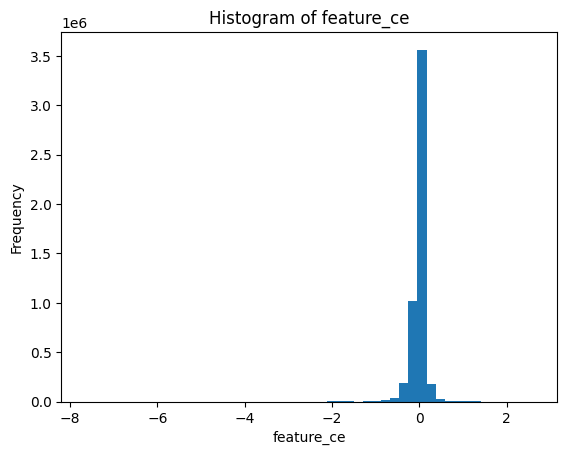

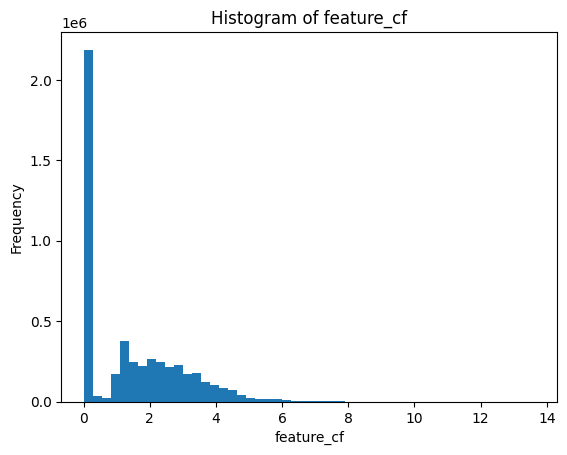

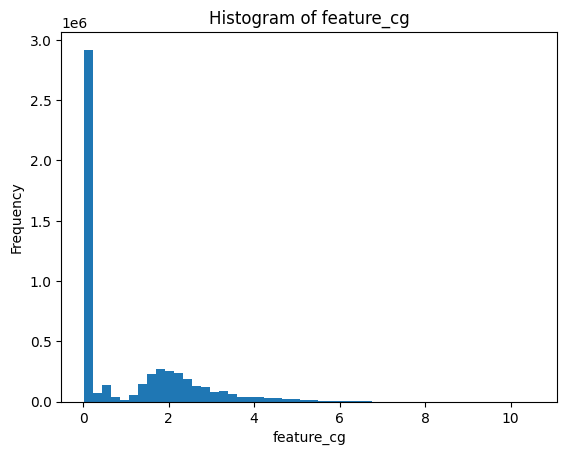

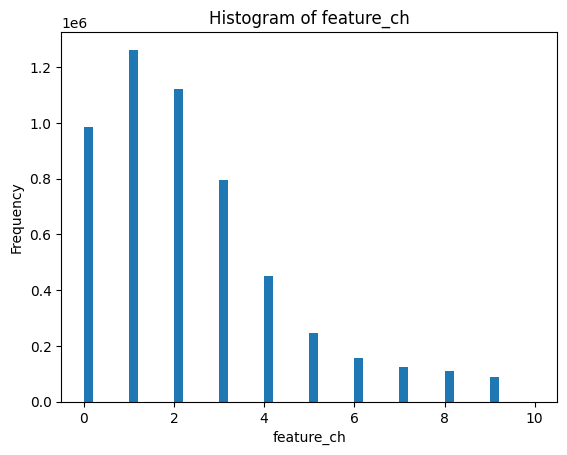

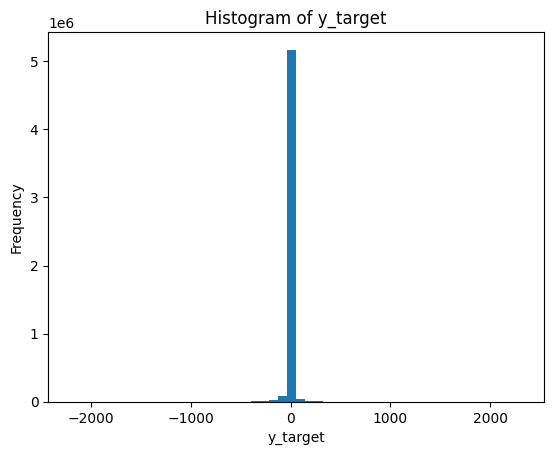

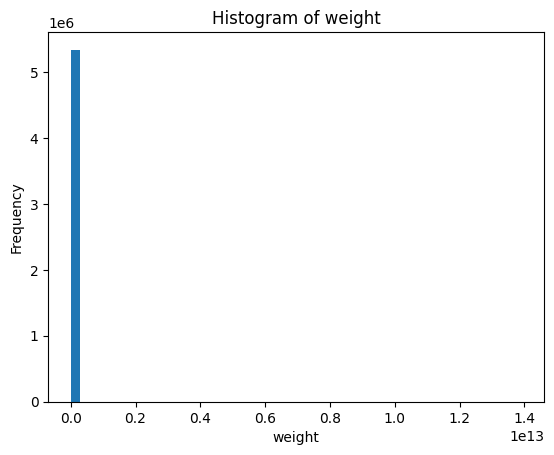

In [36]:
import matplotlib.pyplot as plt

# Loop over columns and plot histograms for each
for col in pdf.columns:
    data = pdf[col].dropna()
    plt.figure()
    if pd.api.types.is_numeric_dtype(data):
        plt.hist(data, bins=50)
        plt.xlabel(col)
        plt.ylabel("Frequency")
        plt.title(f"Histogram of {col}")
        plt.show()
    else:
        # Only plot histogram for numeric columns
        continue
